In [1]:
import torch
from torch import nn, utils
from torch.nn.functional import relu, sigmoid, binary_cross_entropy
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [2]:
# download data
url = 'https://gitlab.com/yuxuan.chen/'\
    'deep-learning-examples/-/raw/master/'\
    '02-Intermediate/mnist.npz'
!wget -nc $url

# load data
with np.load('mnist.npz') as fh:
    data_x = fh['train'].astype(np.float32)
    data_y = fh['train_labels'].astype(np.uint8)

data_x = np.transpose(data_x)
data_y = np.squeeze(np.transpose(data_y))
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# normalization from [0, 255] to [-1, 1]
data_x = (data_x - 127.5) / 127.5
# transform into torch tensor
data_x, data_y = map(torch.tensor, (data_x, data_y))

File 'mnist.npz' already there; not retrieving.

(60000, 784) float32
(60000,) uint8


In [3]:
# hyper-parameters
input_size = 784
hidden_size = 256
latent_size = 32
num_classes = 10
num_epochs = 200
batch_size = 100
learning_rate = 0.0002
weight_decay = 0

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# create dataset and build dataloader
dataset = utils.data.TensorDataset(data_x, data_y)
data_loader = utils.data.DataLoader(dataset=dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    pin_memory=True)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, 
                 conditional=False, num_classes=10):
        super(Discriminator, self).__init__()
        # for vanilla GAN, no class information is required
        self.conditional = conditional
        self.num_classes = num_classes if conditional else 0

        self.fc1 = nn.Sequential(
            nn.Linear(input_size + self.num_classes, hidden_size), 
            nn.LeakyReLU(0.1, inplace=True)) 

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size), 
            nn.LeakyReLU(0.1, inplace=True))
        
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2), 
            nn.LeakyReLU(0.1, inplace=True))

        self.fc4 = nn.Sequential(
            nn.Linear(hidden_size//2, 1), 
            nn.Sigmoid())
    
    def forward(self, x, y=None):
        x = x.view(x.size(0), -1)
        if self.conditional:
            y = nn.functional.one_hot(
                y.to(torch.int64), self.num_classes).to(device)
            x = torch.cat((x, y), dim=-1)
        out = self.fc4(self.fc3(self.fc2(self.fc1(x))))
        return out


class Generator(nn.Module):
    def __init__(self, output_size, hidden_size, latent_size, 
                 conditional=False, num_classes=10):
        super(Generator, self).__init__()
        self.conditional = conditional
        self.num_classes = num_classes if conditional else 0

        self.fc1 = nn.Sequential(
            nn.Linear(latent_size + self.num_classes, hidden_size),
            nn.LeakyReLU(0.1, inplace=True))

        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.1, inplace=True))
        
        self.fc3 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*2),
            nn.LeakyReLU(0.1, inplace=True))

        self.fc4 = nn.Sequential(
            nn.Linear(hidden_size*2, output_size),
            nn.Tanh())
    
    def forward(self, z, y=None):
        z = z.view(z.size(0), -1)
        if self.conditional:
            y = nn.functional.one_hot(
                y.to(torch.int64), self.num_classes).to(device)
            z = torch.cat((z, y), dim=-1)
        out = self.fc4(self.fc3(self.fc2(self.fc1(z))))
        return out

## Vanilla GAN

In [5]:
# set model and optimizer
D = Discriminator(input_size, hidden_size).to(device)
G = Generator(input_size, hidden_size, latent_size).to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(params=D.parameters(), 
                               lr=learning_rate, 
                               weight_decay=weight_decay)
g_optimizer = torch.optim.Adam(params=G.parameters(), 
                               lr=learning_rate, 
                               weight_decay=weight_decay)

Epoch [50/200], d_loss: 0.7710, g_loss: 1.6857


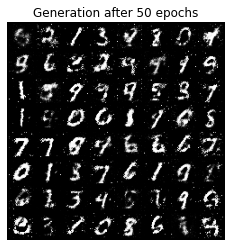

Epoch [100/200], d_loss: 1.3100, g_loss: 1.2177


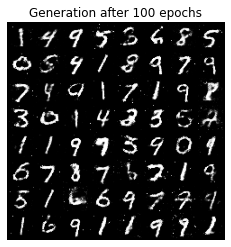

Epoch [150/200], d_loss: 1.0739, g_loss: 1.1386


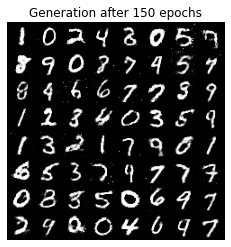

Epoch [200/200], d_loss: 1.0137, g_loss: 1.1327


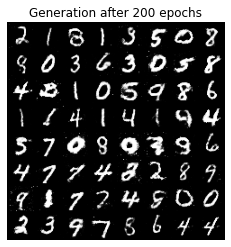

In [6]:
# start training
for epoch in range(num_epochs):
    for images, _ in data_loader:
        images = images.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ===== TRAIN THE DISCRIMINATOR =====
        # compute loss using real images and real labels
        pred_real = D(images)
        d_loss_real = criterion(pred_real, real_labels)
        
        # compute loss using fake images and fake labels
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        pred_fake = D(fake_images)
        d_loss_fake = criterion(pred_fake, fake_labels)

        # b-p to update discriminator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
    
        # ===== TRAIN THE GENERATOR =====
        # compute loss using fake images and real labels
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        pred_fake = D(fake_images)
        g_loss = criterion(pred_fake, real_labels)

        # b-p to update generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    # print results for the last batch after every some epochs
    if (epoch + 1) % 50 == 0:
        print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch + 1, num_epochs, d_loss, g_loss))

        # save image
        fake_images = ((fake_images + 1) / 2)
        fake_images = fake_images[:64].view(-1, 1, 28, 28)
        save_image(fake_images, 'fake-images.png', nrow=8)
        
        # plot
        img = mpimg.imread('fake-images.png')
        plt.axis('off')
        plt.imshow(img)
        plt.title('Generation after {} epochs'.format(epoch + 1))
        plt.show()

### Conditional GAN

In [7]:
# set model and optimizer
D = Discriminator(input_size, hidden_size, 
                  conditional=True, num_classes=num_classes).to(device)
G = Generator(input_size, hidden_size, latent_size, 
              conditional=True, num_classes=num_classes).to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(params=D.parameters(), 
                               lr=learning_rate, 
                               weight_decay=weight_decay)
g_optimizer = torch.optim.Adam(params=G.parameters(), 
                               lr=learning_rate, 
                               weight_decay=weight_decay)

Epoch [50/200], d_loss: 1.0666, g_loss: 1.5151
[[7 8 6 1 9 5 3 4]
 [4 2 9 6 7 6 9 8]
 [8 0 7 7 9 9 6 9]
 [8 5 1 9 6 1 9 5]
 [3 4 6 7 2 9 0 9]
 [9 1 2 5 4 1 3 3]
 [4 4 8 8 0 3 3 0]
 [5 9 0 1 2 8 2 0]]


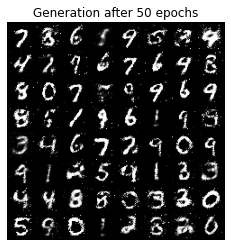

Epoch [100/200], d_loss: 1.3761, g_loss: 0.9785
[[6 3 0 6 5 2 2 2]
 [2 6 5 8 6 6 9 3]
 [9 4 5 2 8 5 9 6]
 [1 2 0 8 2 0 2 1]
 [4 5 9 4 8 6 7 0]
 [5 5 6 9 1 4 5 2]
 [8 1 8 2 7 8 0 5]
 [2 9 0 8 1 3 2 9]]


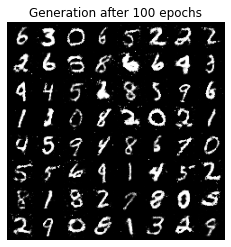

Epoch [150/200], d_loss: 1.3371, g_loss: 0.8708
[[4 9 3 0 7 5 9 4]
 [5 0 7 0 8 7 6 3]
 [9 3 5 6 5 1 2 2]
 [9 9 1 1 7 0 4 7]
 [9 1 8 4 2 3 4 7]
 [6 1 2 4 7 6 2 7]
 [1 8 0 0 8 8 7 8]
 [7 0 1 3 6 0 5 3]]


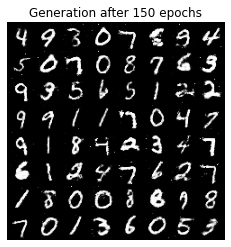

Epoch [200/200], d_loss: 1.1813, g_loss: 1.1398
[[6 2 8 1 6 7 2 8]
 [8 8 8 6 8 2 7 8]
 [4 9 7 4 8 8 1 4]
 [2 3 2 7 5 4 6 8]
 [5 3 3 4 3 8 5 0]
 [3 4 7 5 5 0 4 0]
 [7 4 7 3 8 2 1 4]
 [0 9 1 8 4 0 2 9]]


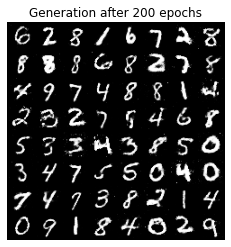

In [8]:
# start training
for epoch in range(num_epochs):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ===== TRAIN THE DISCRIMINATOR =====
        # compute loss using real images and real labels
        pred_real = D(images, labels)
        d_loss_real = criterion(pred_real, real_labels)
        
        # compute loss using fake images and fake labels
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z, labels)
        pred_fake = D(fake_images, labels)
        d_loss_fake = criterion(pred_fake, fake_labels)

        # b-p to update discriminator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
    
        # ===== TRAIN THE GENERATOR =====
        # compute loss using fake images and real labels
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z, labels)
        pred_fake = D(fake_images, labels)
        g_loss = criterion(pred_fake, real_labels)

        # b-p to update generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
    
    # print results for the last batch after every some epochs
    if (epoch + 1) % 50 == 0:
        print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch + 1, num_epochs, d_loss, g_loss))

        # save image
        fake_images = ((fake_images + 1) / 2)
        fake_images = fake_images[:64].view(-1, 1, 28, 28)
        save_image(fake_images, 'fake-images.png', nrow=8)

        # print labels
        labels = labels.cpu().numpy()
        print(np.reshape(labels[:64], (8, 8)))
        
        # plot
        img = mpimg.imread('fake-images.png')
        plt.axis('off')
        plt.imshow(img)
        plt.title('Generation after {} epochs'.format(epoch + 1))
        plt.show()